# Generate Bounding Boxes

In [24]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, convert_map_to_road_map

from bb_helper import draw_bounding_boxes

from PIL import Image

In [25]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [26]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '..\\..\\data'
annotation_csv = '../../data/annotation.csv'

In [27]:
# unlabeled_scene_index = np.arange(106)
labeled_scene_index = np.arange(125, 134) # default (106, 134)

In [28]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=False # Can change to true and get extra info
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [29]:
# ### GENERATE ROAD MAPS AND IMAGES ###

# for sample, target, road_image, boxes, sample_path in trainloader:
#     print(sample_path)
    
#     boxes_path = os.path.join(sample_path, 'boxes.png')

In [30]:
sample, target, road_image, boxes, sample_path = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([1, 6, 3, 256, 306])


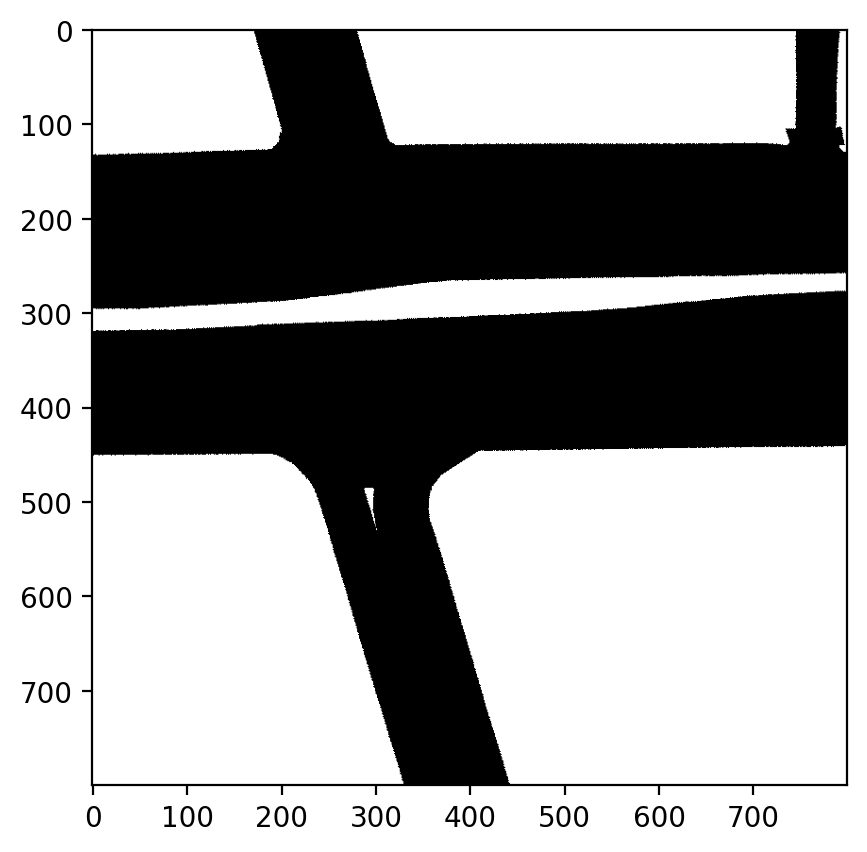

In [31]:
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

# Convert bounding box coordinates to binary map

In [32]:
def draw_box(ax, corners):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color='black', linewidth=0.5)

torch.Size([800, 800])


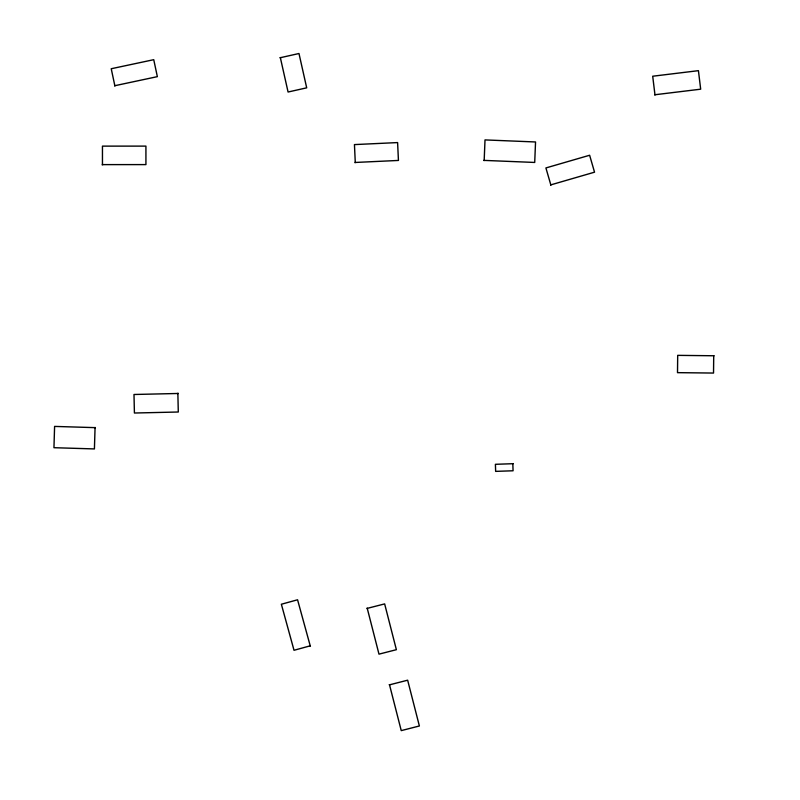

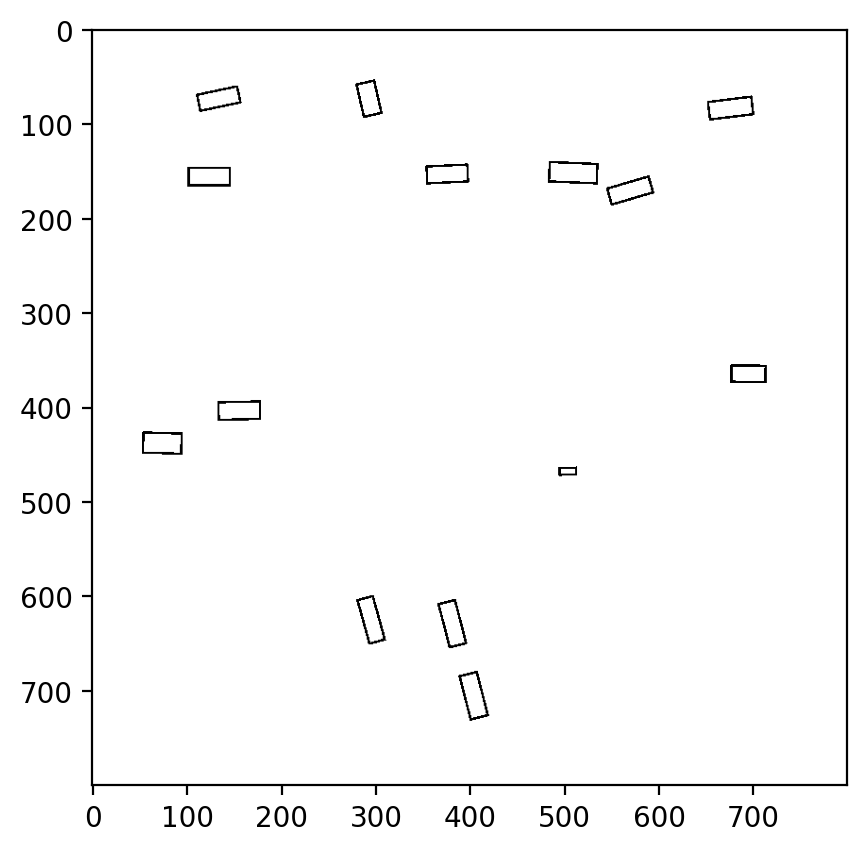

In [33]:
### Plot empty background (or negative roadmap) ###
fig, ax = plt.subplots()
plt.axis('off')
background = torch.zeros((800,800)) > 0
# background = road_image[0] != True
ax.imshow(background, cmap='binary');

### Draw Boxes ###
for i, bb in enumerate(boxes[0]):
    draw_box(ax, bb)

### Ensure DPI is Correct and Save Image ###
DPI = 200
matplotlib.rcParams['figure.dpi'] = DPI
fig.set_size_inches(1007.0/float(DPI),1007.0/float(DPI)) 
plt.savefig("temp.png", bbox_inches='tight', dpi=DPI)

### Read Image and Convert to Tensor ###
bb_image = Image.open("temp.png")
bb_image = torchvision.transforms.functional.to_tensor(bb_image)
new_image = convert_map_to_road_map(bb_image)
print(new_image.shape)
fig, ax = plt.subplots()
ax.imshow(new_image, cmap='binary');

torch.Size([800, 800])


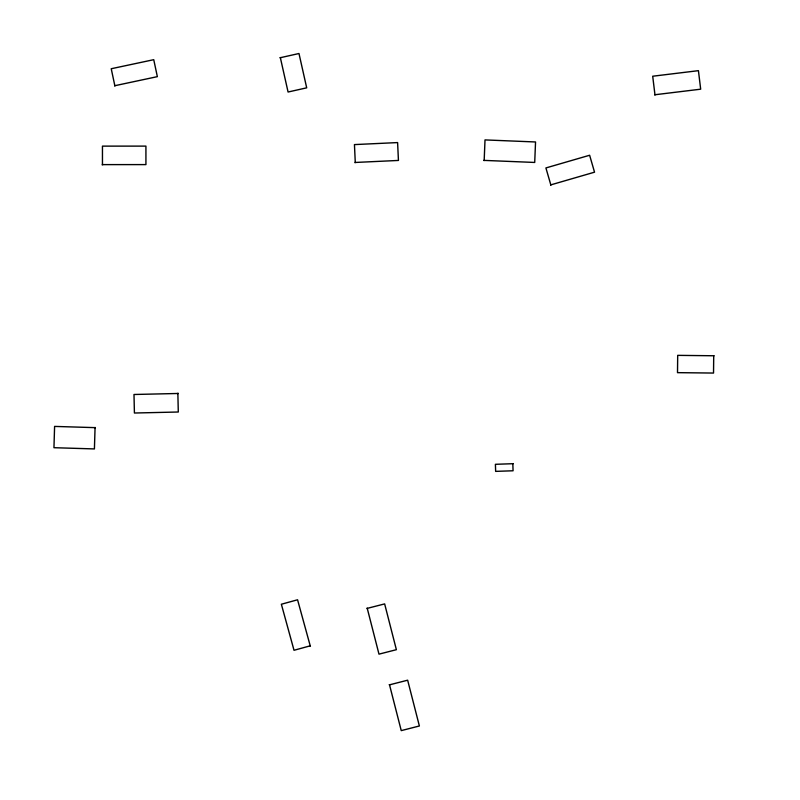

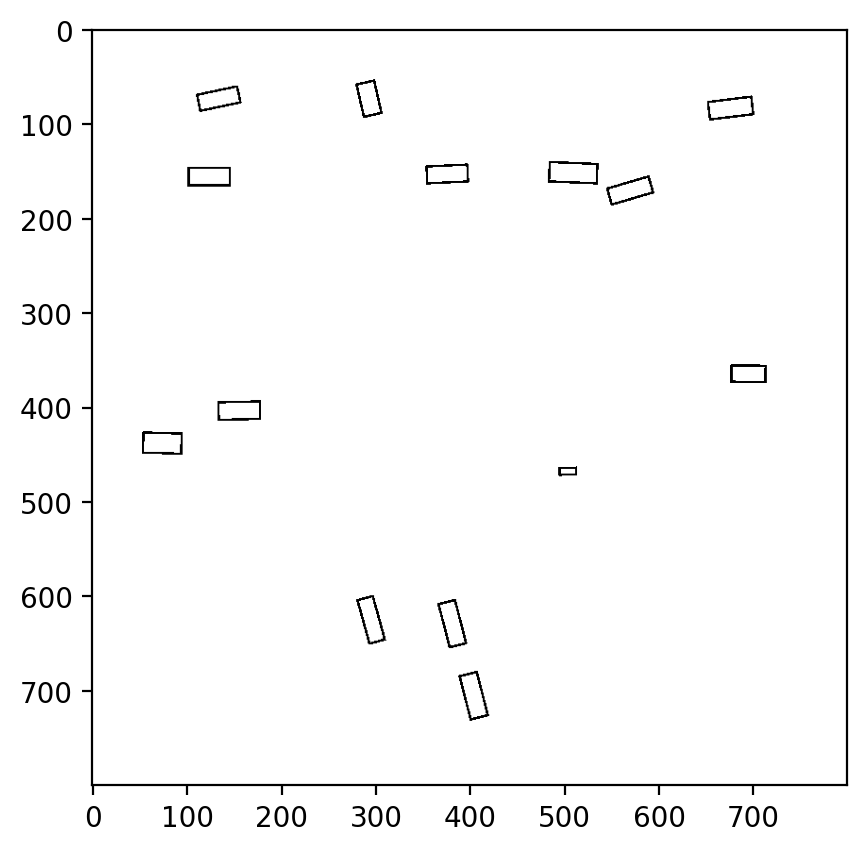

In [34]:
# Test bb_helper
draw_bounding_boxes(boxes[0])